Main Changes: 
1) Architecture - VGG-like 
2) learning rate - 0.1 > 0.01 (Because #2 had issue seem like gradient exploding)
3) dataset normalize - 0.5 > reasonable values
4) removed useless reshape before train in CIFAR-10

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import sys
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 하이퍼파라미터 설정
exp_num = -1     # To save the result, change every time. -1 to not save.
num_epochs = 10
learning_rate = 0.01
dropout_prob = 0.5

if exp_num!=-1: os.mkdir(f'./Result{exp_num}')

In [3]:
# 가중치 드랍아웃 레이어
class WeightDropout(nn.Module):
    def __init__(self, module, p=0.5):
        super(WeightDropout, self).__init__()
        self.module = module
        self.p = p
        self.weight = nn.Parameter(module.weight.data)

    def forward(self, *args):
        if self.training:
            # dropout을 적용한 가중치
            weight = F.dropout(self.weight, p=self.p, training=True)
            # self.module.weight에 새로운 가중치 할당
            self.module.weight = nn.Parameter(weight)
        return self.module(*args)

# ***Basic Code***

In [4]:
def dataset_MNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader


def dataset_CIFAR10():
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
  ])
  train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

In [5]:
# 모델 학습 함수
def Run(num_epochs, dataset, method):
  if dataset=='MNIST': train_loader, test_loader = dataset_MNIST()
  elif dataset=='CIFAR-10': train_loader, test_loader = dataset_CIFAR10()

  # Save log
  if exp_num!=-1:
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'w')
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'a')

  model.to(device)
  train_acc_list = []
  test_acc_list = []
  train_loss_list = []
  test_loss_list = []
  
  for epoch in range(num_epochs):
      # Train
      model.train()
      train_loss, train_correct = 0, 0
      for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
      train_loss /= len(train_loader.dataset)
      train_accuracy = train_correct / len(train_loader.dataset)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      # Test
      model.eval()
      test_loss, test_correct = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
          test_loss /= len(test_loader.dataset)
          test_accuracy = test_correct / len(test_loader.dataset)
          test_acc_list.append(test_accuracy)
          test_loss_list.append(test_loss)

      # Show Result
      print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.8f} | Train Accuracy: {round(train_accuracy*100, 2):.6f} | '
            f'Test Loss: {test_loss:.8f} | Test Accuracy: {round(test_accuracy*100, 2):.6f}')

  return train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [6]:
# 그래프
def plot(dataset, method, exp_num):
    figname = f"[{dataset}] {method}  #{exp_num}.png"
    plt.figure(figsize=(10, 6), dpi=1000)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if exp_num != -1 : plt.savefig(f'./Result{exp_num}/'+figname)
    plt.show()

# ***Experiments***

## 1) [MNIST] VGG-like without Dropout

In [7]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'NoDrop')

Epoch  1 | Train Loss: 0.01369209 | Train Accuracy: 75.100000 | Test Loss: 0.00321066 | Test Accuracy: 93.650000
Epoch  2 | Train Loss: 0.00192135 | Train Accuracy: 96.280000 | Test Loss: 0.00146557 | Test Accuracy: 96.980000
Epoch  3 | Train Loss: 0.00116979 | Train Accuracy: 97.660000 | Test Loss: 0.00127111 | Test Accuracy: 97.420000
Epoch  4 | Train Loss: 0.00085883 | Train Accuracy: 98.310000 | Test Loss: 0.00101802 | Test Accuracy: 97.920000
Epoch  5 | Train Loss: 0.00067014 | Train Accuracy: 98.680000 | Test Loss: 0.00093126 | Test Accuracy: 98.090000
Epoch  6 | Train Loss: 0.00053396 | Train Accuracy: 98.950000 | Test Loss: 0.00086378 | Test Accuracy: 98.320000
Epoch  7 | Train Loss: 0.00042300 | Train Accuracy: 99.210000 | Test Loss: 0.00083600 | Test Accuracy: 98.390000
Epoch  8 | Train Loss: 0.00033613 | Train Accuracy: 99.390000 | Test Loss: 0.00083816 | Test Accuracy: 98.370000
Epoch  9 | Train Loss: 0.00026520 | Train Accuracy: 99.560000 | Test Loss: 0.00083070 | Test Acc

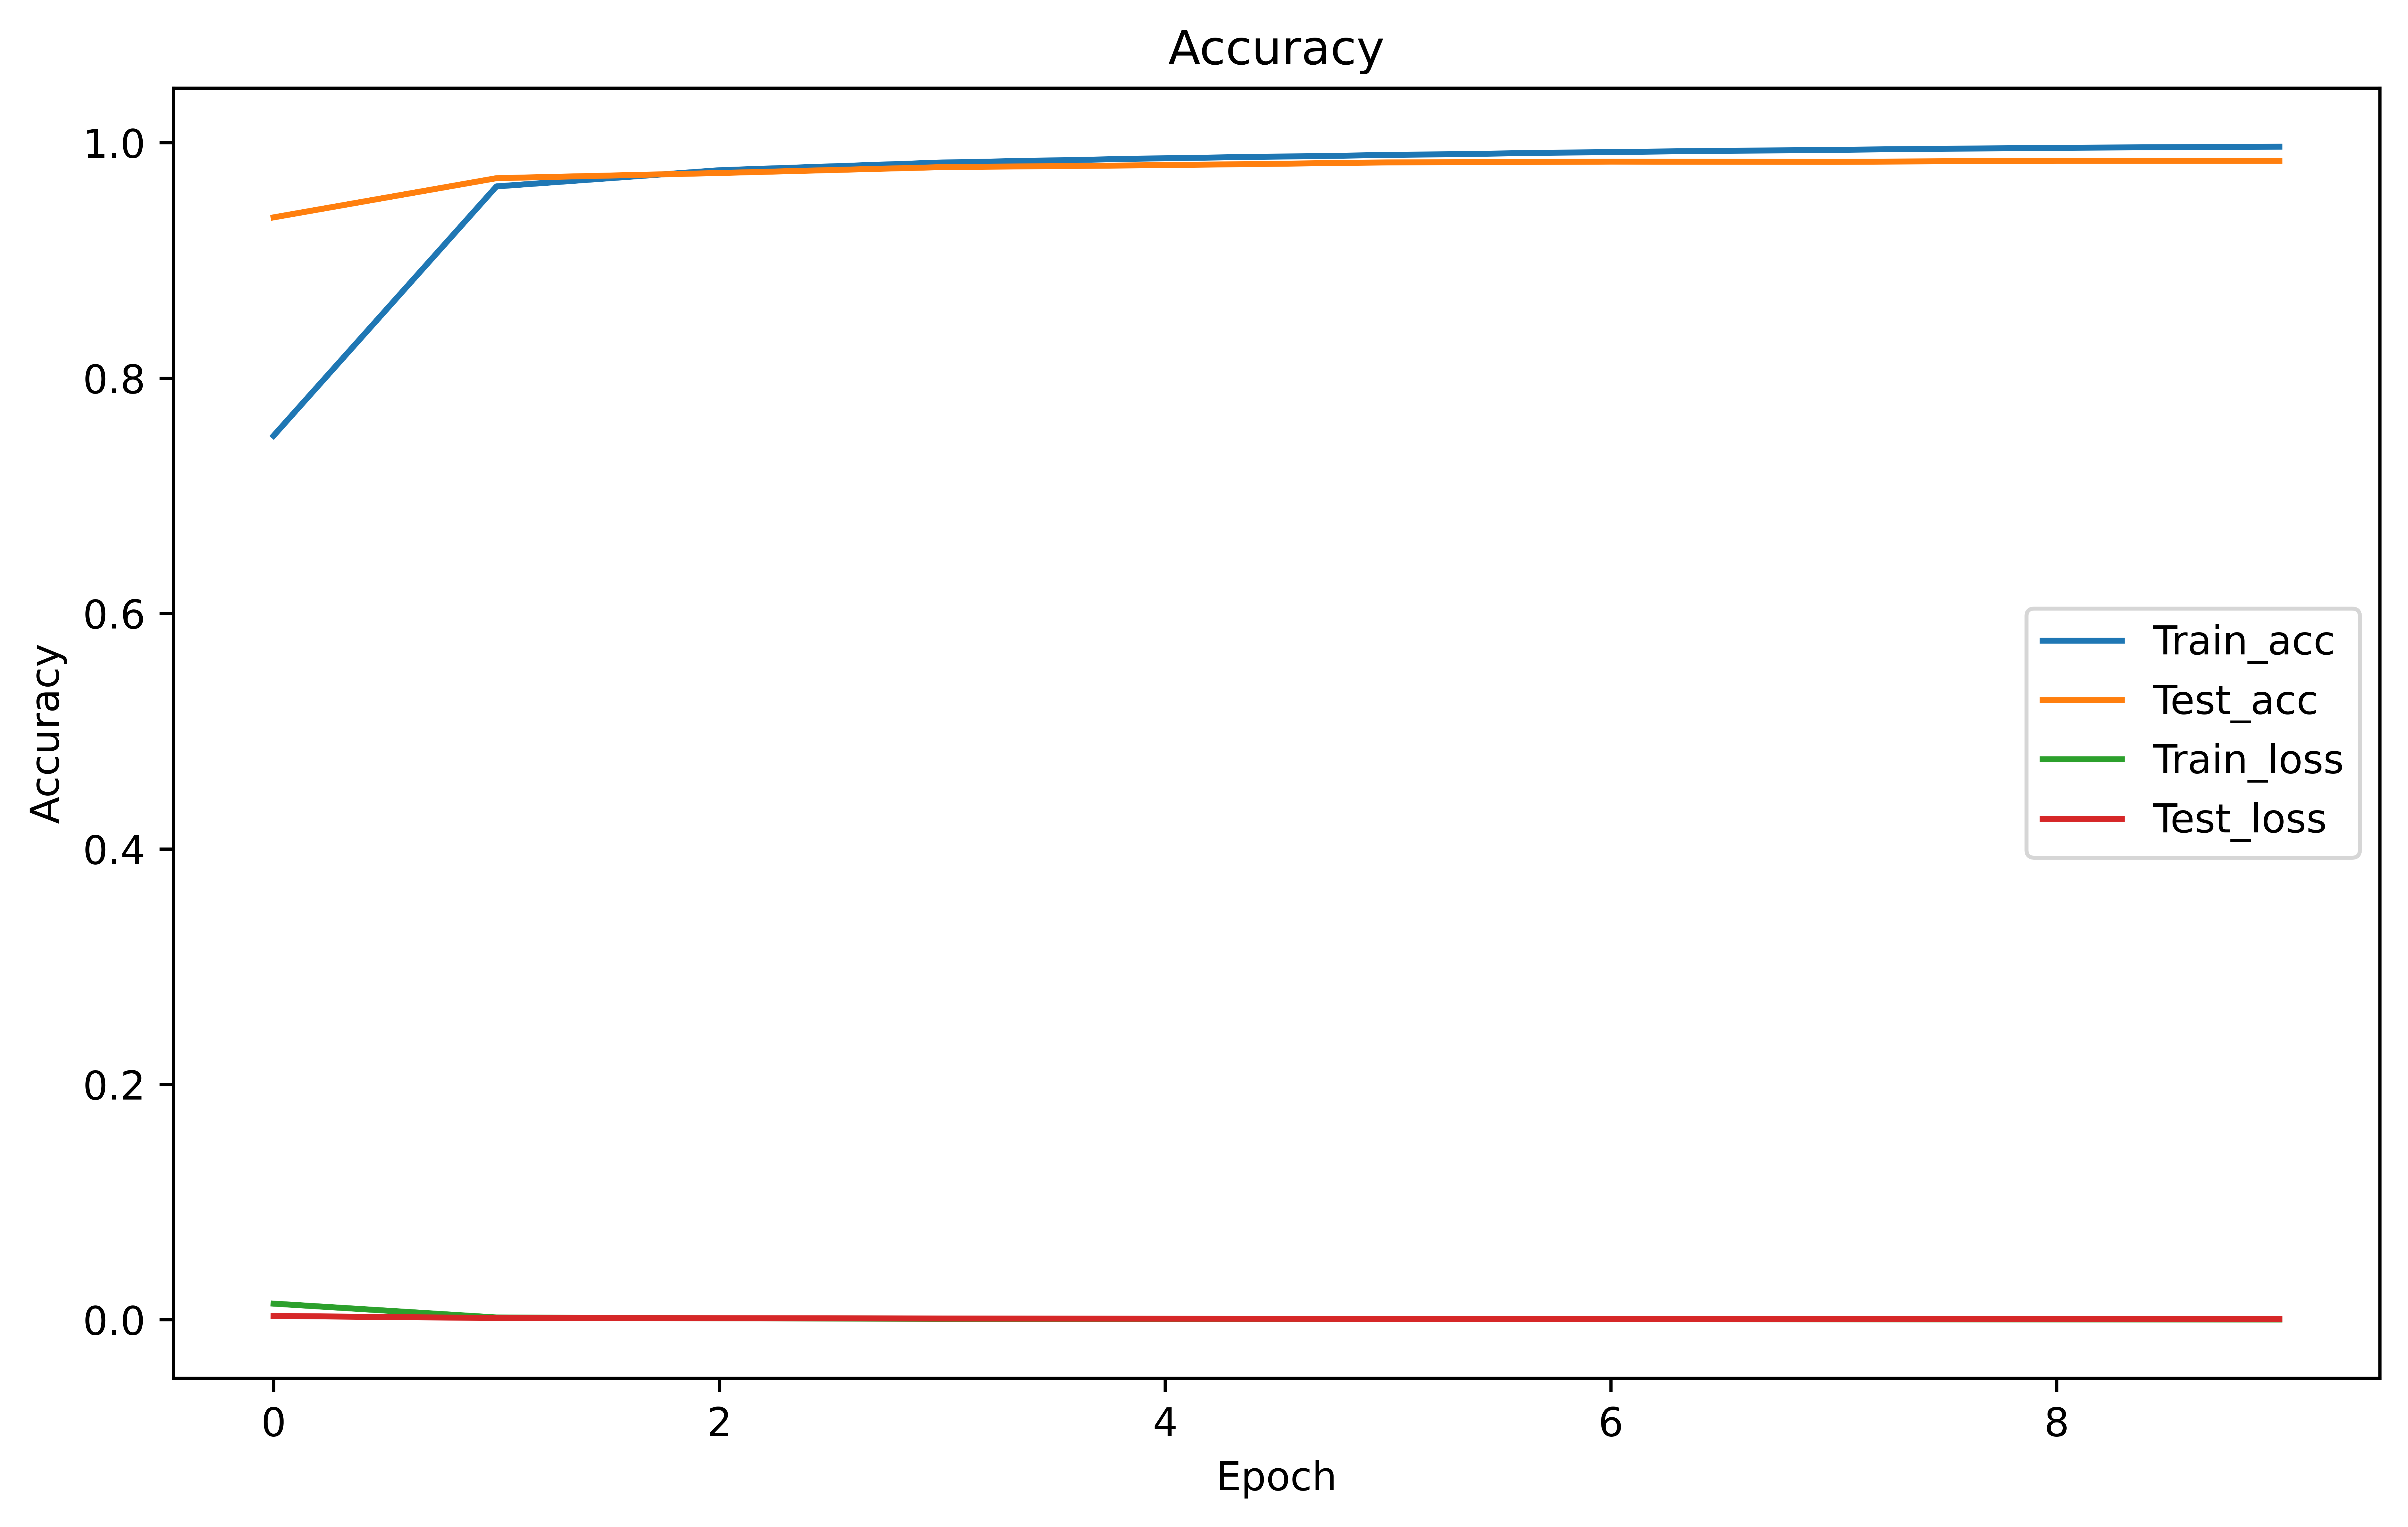

In [8]:
plot('MNIST', 'NoDrop', exp_num)

## 2) [MNIST] VGG-like with Dropout

In [9]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'Drop')

Epoch  1 | Train Loss: 0.01819181 | Train Accuracy: 62.530000 | Test Loss: 0.00325400 | Test Accuracy: 93.160000
Epoch  2 | Train Loss: 0.00249787 | Train Accuracy: 95.120000 | Test Loss: 0.00137935 | Test Accuracy: 96.950000
Epoch  3 | Train Loss: 0.00159669 | Train Accuracy: 96.830000 | Test Loss: 0.00105427 | Test Accuracy: 97.770000
Epoch  4 | Train Loss: 0.00120933 | Train Accuracy: 97.600000 | Test Loss: 0.00088019 | Test Accuracy: 98.150000
Epoch  5 | Train Loss: 0.00100971 | Train Accuracy: 98.050000 | Test Loss: 0.00075484 | Test Accuracy: 98.460000
Epoch  6 | Train Loss: 0.00086050 | Train Accuracy: 98.350000 | Test Loss: 0.00062795 | Test Accuracy: 98.610000
Epoch  7 | Train Loss: 0.00075544 | Train Accuracy: 98.470000 | Test Loss: 0.00061949 | Test Accuracy: 98.720000
Epoch  8 | Train Loss: 0.00067798 | Train Accuracy: 98.710000 | Test Loss: 0.00055314 | Test Accuracy: 98.760000
Epoch  9 | Train Loss: 0.00060532 | Train Accuracy: 98.780000 | Test Loss: 0.00050832 | Test Acc

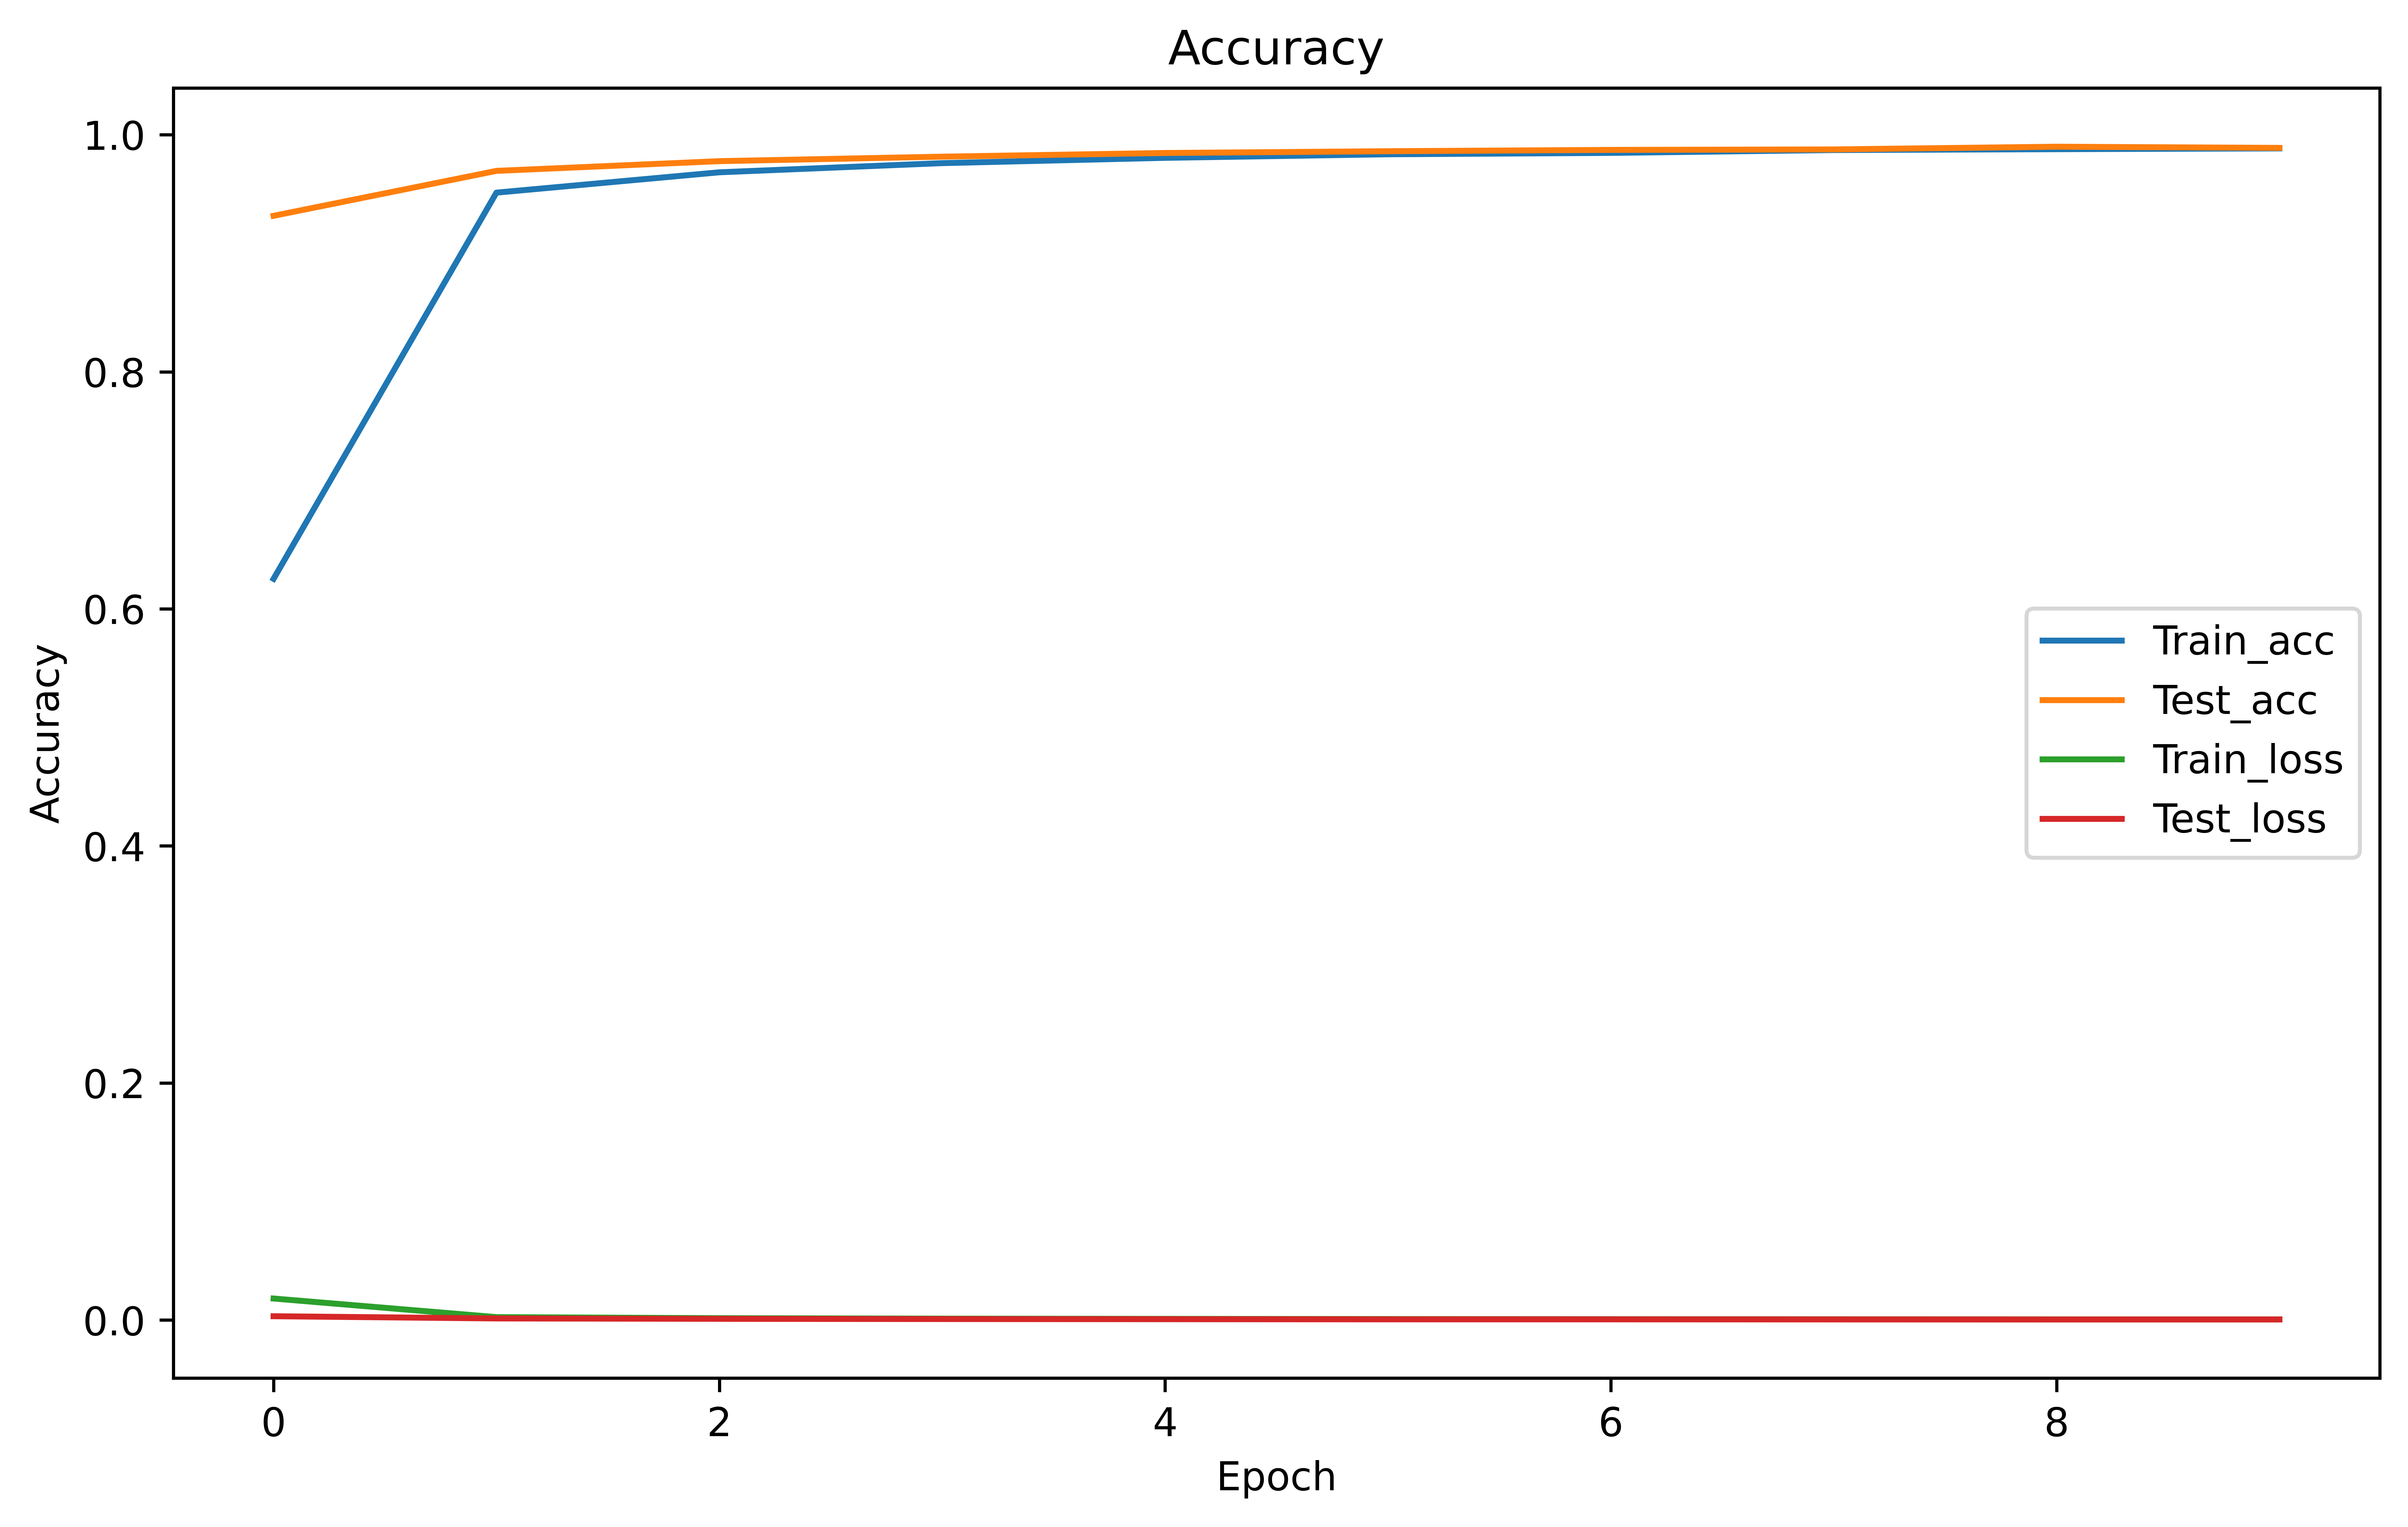

In [10]:
plot('MNIST', 'Drop', exp_num)

## 3) [MNIST] VGG-like with Weight Dropout

In [11]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(4*4*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'WeightDrop')

Epoch  1 | Train Loss: 0.02827433 | Train Accuracy: 38.960000 | Test Loss: 0.01138276 | Test Accuracy: 75.320000
Epoch  2 | Train Loss: 0.00640555 | Train Accuracy: 87.050000 | Test Loss: 0.00472474 | Test Accuracy: 90.050000
Epoch  3 | Train Loss: 0.00385195 | Train Accuracy: 92.250000 | Test Loss: 0.00294743 | Test Accuracy: 93.940000
Epoch  4 | Train Loss: 0.00306544 | Train Accuracy: 93.940000 | Test Loss: 0.00222795 | Test Accuracy: 95.470000
Epoch  5 | Train Loss: 0.00261570 | Train Accuracy: 94.720000 | Test Loss: 0.00249728 | Test Accuracy: 94.900000
Epoch  6 | Train Loss: 0.00234159 | Train Accuracy: 95.460000 | Test Loss: 0.00192491 | Test Accuracy: 95.850000
Epoch  7 | Train Loss: 0.00211859 | Train Accuracy: 95.790000 | Test Loss: 0.00177773 | Test Accuracy: 96.490000
Epoch  8 | Train Loss: 0.00195409 | Train Accuracy: 96.080000 | Test Loss: 0.00203006 | Test Accuracy: 95.710000
Epoch  9 | Train Loss: 0.00179290 | Train Accuracy: 96.420000 | Test Loss: 0.00158441 | Test Acc

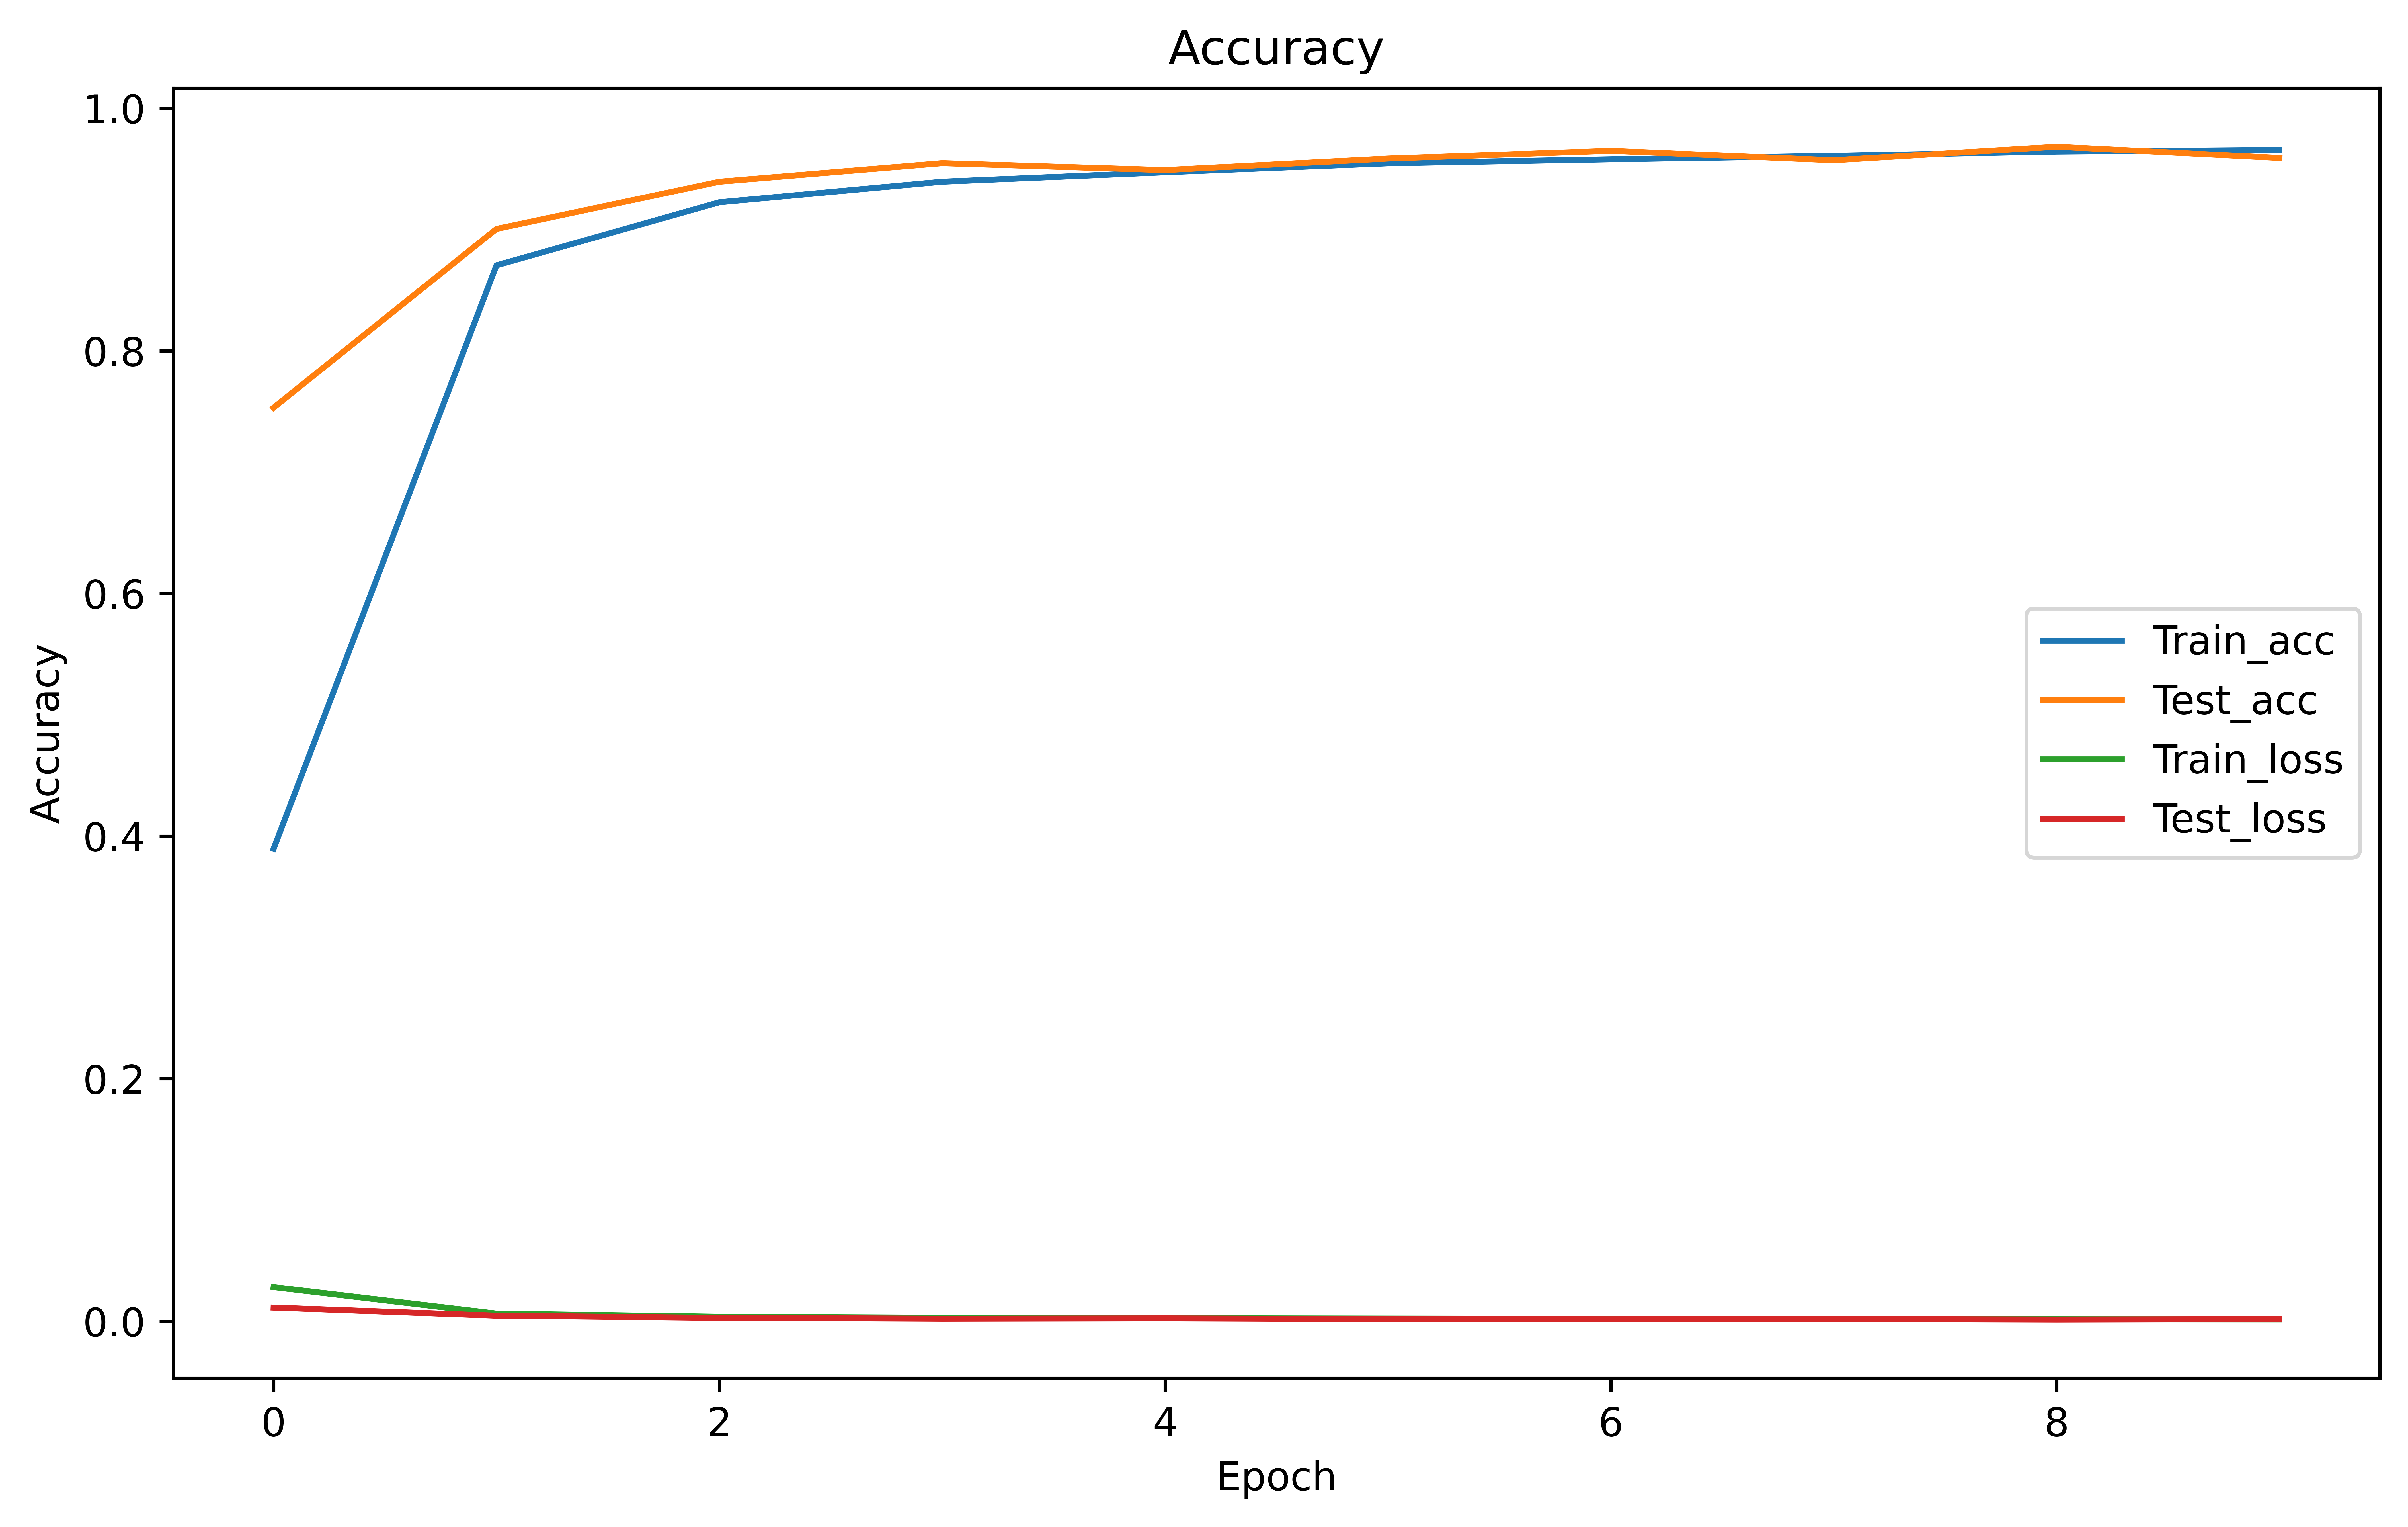

In [12]:
plot('MNIST', 'WD', exp_num)

## 1) [CIFAR-10] VGG16-like without Dropout

In [13]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'NoDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03589159 | Train Accuracy: 12.100000 | Test Loss: 0.03537717 | Test Accuracy: 19.880000
Epoch  2 | Train Loss: 0.03056308 | Train Accuracy: 30.020000 | Test Loss: 0.02829949 | Test Accuracy: 33.090000
Epoch  3 | Train Loss: 0.02632411 | Train Accuracy: 38.980000 | Test Loss: 0.02771712 | Test Accuracy: 34.120000
Epoch  4 | Train Loss: 0.02413517 | Train Accuracy: 44.170000 | Test Loss: 0.02690158 | Test Accuracy: 37.210000
Epoch  5 | Train Loss: 0.02260384 | Train Accuracy: 48.050000 | Test Loss: 0.02589582 | Test Accuracy: 40.500000
Epoch  6 | Train Loss: 0.02118453 | Train Accuracy: 51.550000 | Test Loss: 0.02498028 | Test Accuracy: 44.120000
Epoch  7 | Train Loss: 0.01985797 | Train Accuracy: 54.840000 | Test Loss: 0.02448465 | Test Accuracy: 46.310000
Epoch  8 | Train Loss: 0.01861079 | Train Accuracy: 57.860000 | Test Loss: 0.02319583 | Test Accuracy: 49.160000
Epoch  9 | Train Los

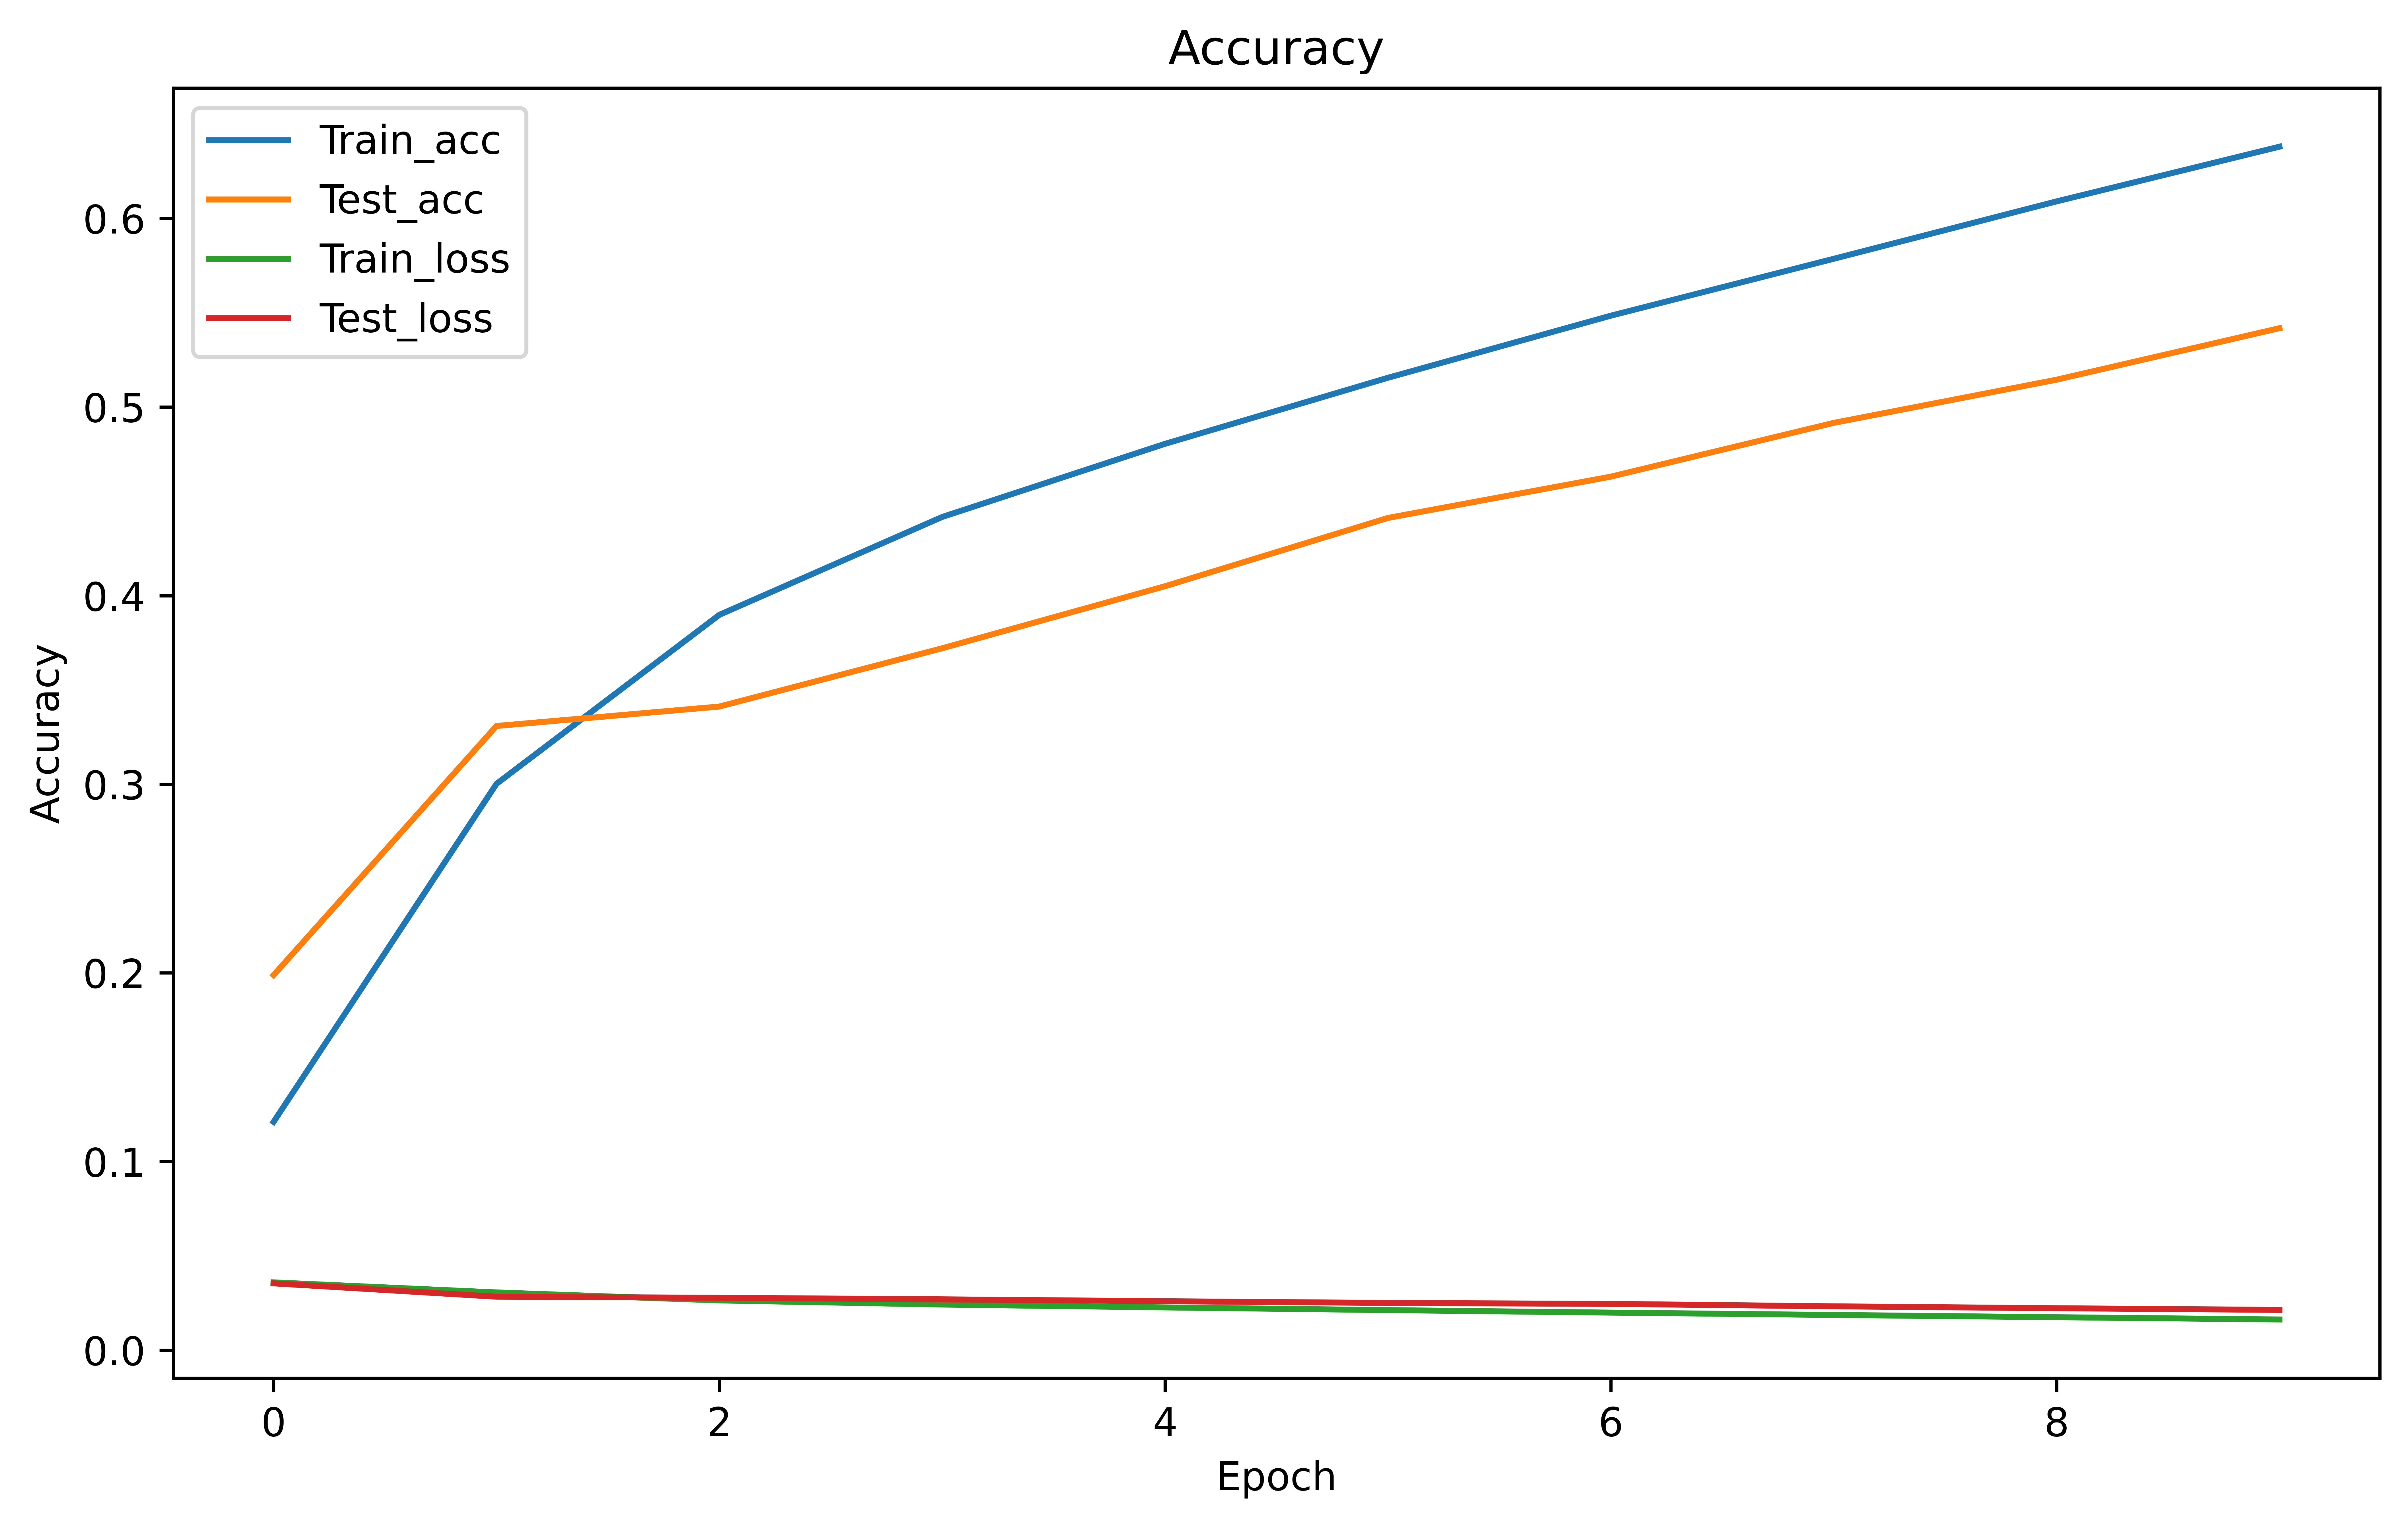

In [14]:
plot('CIFAR10', 'NoDrop', exp_num)

## 2) [CIFAR-10] VGG-like with Dropout

In [15]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'Drop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03534862 | Train Accuracy: 15.470000 | Test Loss: 0.03338780 | Test Accuracy: 24.930000
Epoch  2 | Train Loss: 0.03111916 | Train Accuracy: 28.200000 | Test Loss: 0.02904174 | Test Accuracy: 32.910000
Epoch  3 | Train Loss: 0.02742904 | Train Accuracy: 36.520000 | Test Loss: 0.02579402 | Test Accuracy: 38.650000
Epoch  4 | Train Loss: 0.02485713 | Train Accuracy: 42.050000 | Test Loss: 0.02442190 | Test Accuracy: 42.290000
Epoch  5 | Train Loss: 0.02329734 | Train Accuracy: 45.850000 | Test Loss: 0.02337413 | Test Accuracy: 44.800000
Epoch  6 | Train Loss: 0.02200262 | Train Accuracy: 49.160000 | Test Loss: 0.02209575 | Test Accuracy: 48.470000
Epoch  7 | Train Loss: 0.02081109 | Train Accuracy: 52.350000 | Test Loss: 0.02152868 | Test Accuracy: 50.470000
Epoch  8 | Train Loss: 0.01967945 | Train Accuracy: 55.190000 | Test Loss: 0.02099059 | Test Accuracy: 52.240000
Epoch  9 | Train Los

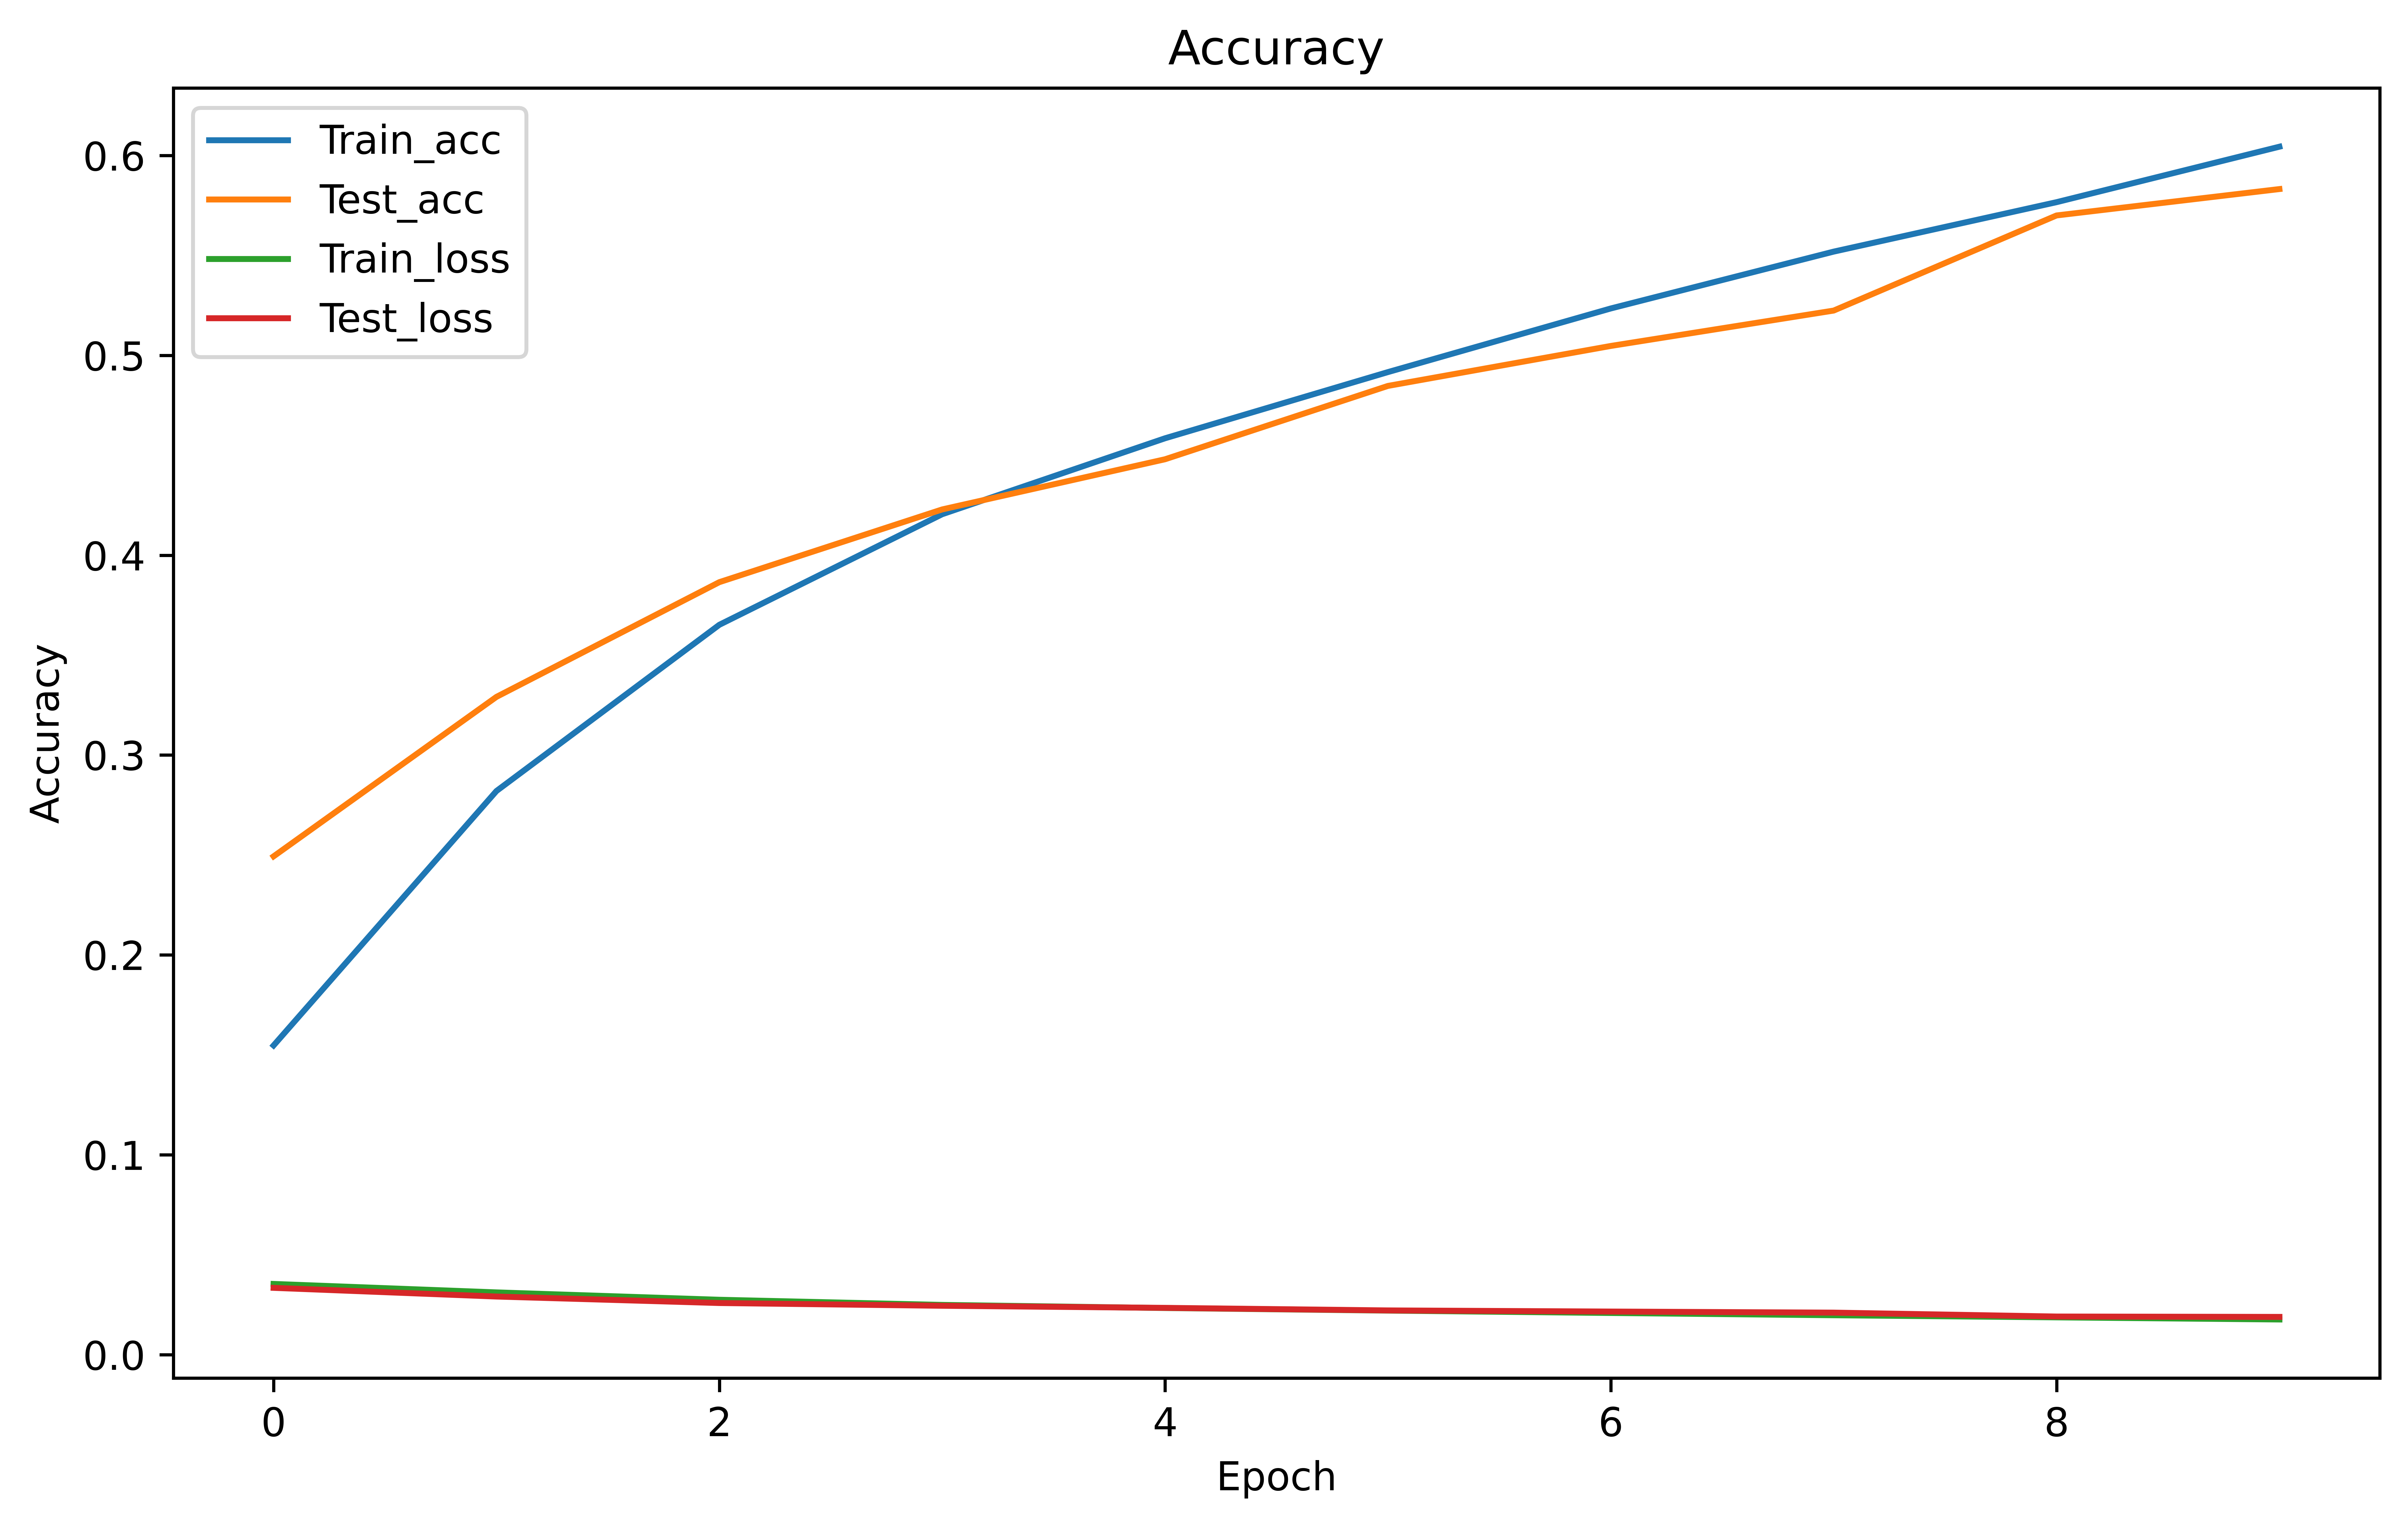

In [16]:
plot('CIFAR10', 'Drop', exp_num)

## 3) [CIFAR-10] VGG-like Weight Dropout

In [17]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(5*5*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'WeightDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03599279 | Train Accuracy: 10.850000 | Test Loss: 0.03609031 | Test Accuracy: 10.060000
Epoch  2 | Train Loss: 0.03571702 | Train Accuracy: 13.020000 | Test Loss: 0.03494709 | Test Accuracy: 13.810000
Epoch  3 | Train Loss: 0.03252383 | Train Accuracy: 24.250000 | Test Loss: 0.03225845 | Test Accuracy: 24.440000
Epoch  4 | Train Loss: 0.03074407 | Train Accuracy: 28.680000 | Test Loss: 0.03126281 | Test Accuracy: 26.480000
Epoch  5 | Train Loss: 0.02939771 | Train Accuracy: 32.010000 | Test Loss: 0.03012143 | Test Accuracy: 28.430000
Epoch  6 | Train Loss: 0.02780569 | Train Accuracy: 35.270000 | Test Loss: 0.02964754 | Test Accuracy: 29.660000
Epoch  7 | Train Loss: 0.02659498 | Train Accuracy: 37.560000 | Test Loss: 0.02841590 | Test Accuracy: 33.560000
Epoch  8 | Train Loss: 0.02580818 | Train Accuracy: 39.170000 | Test Loss: 0.02766256 | Test Accuracy: 34.530000
Epoch  9 | Train Los

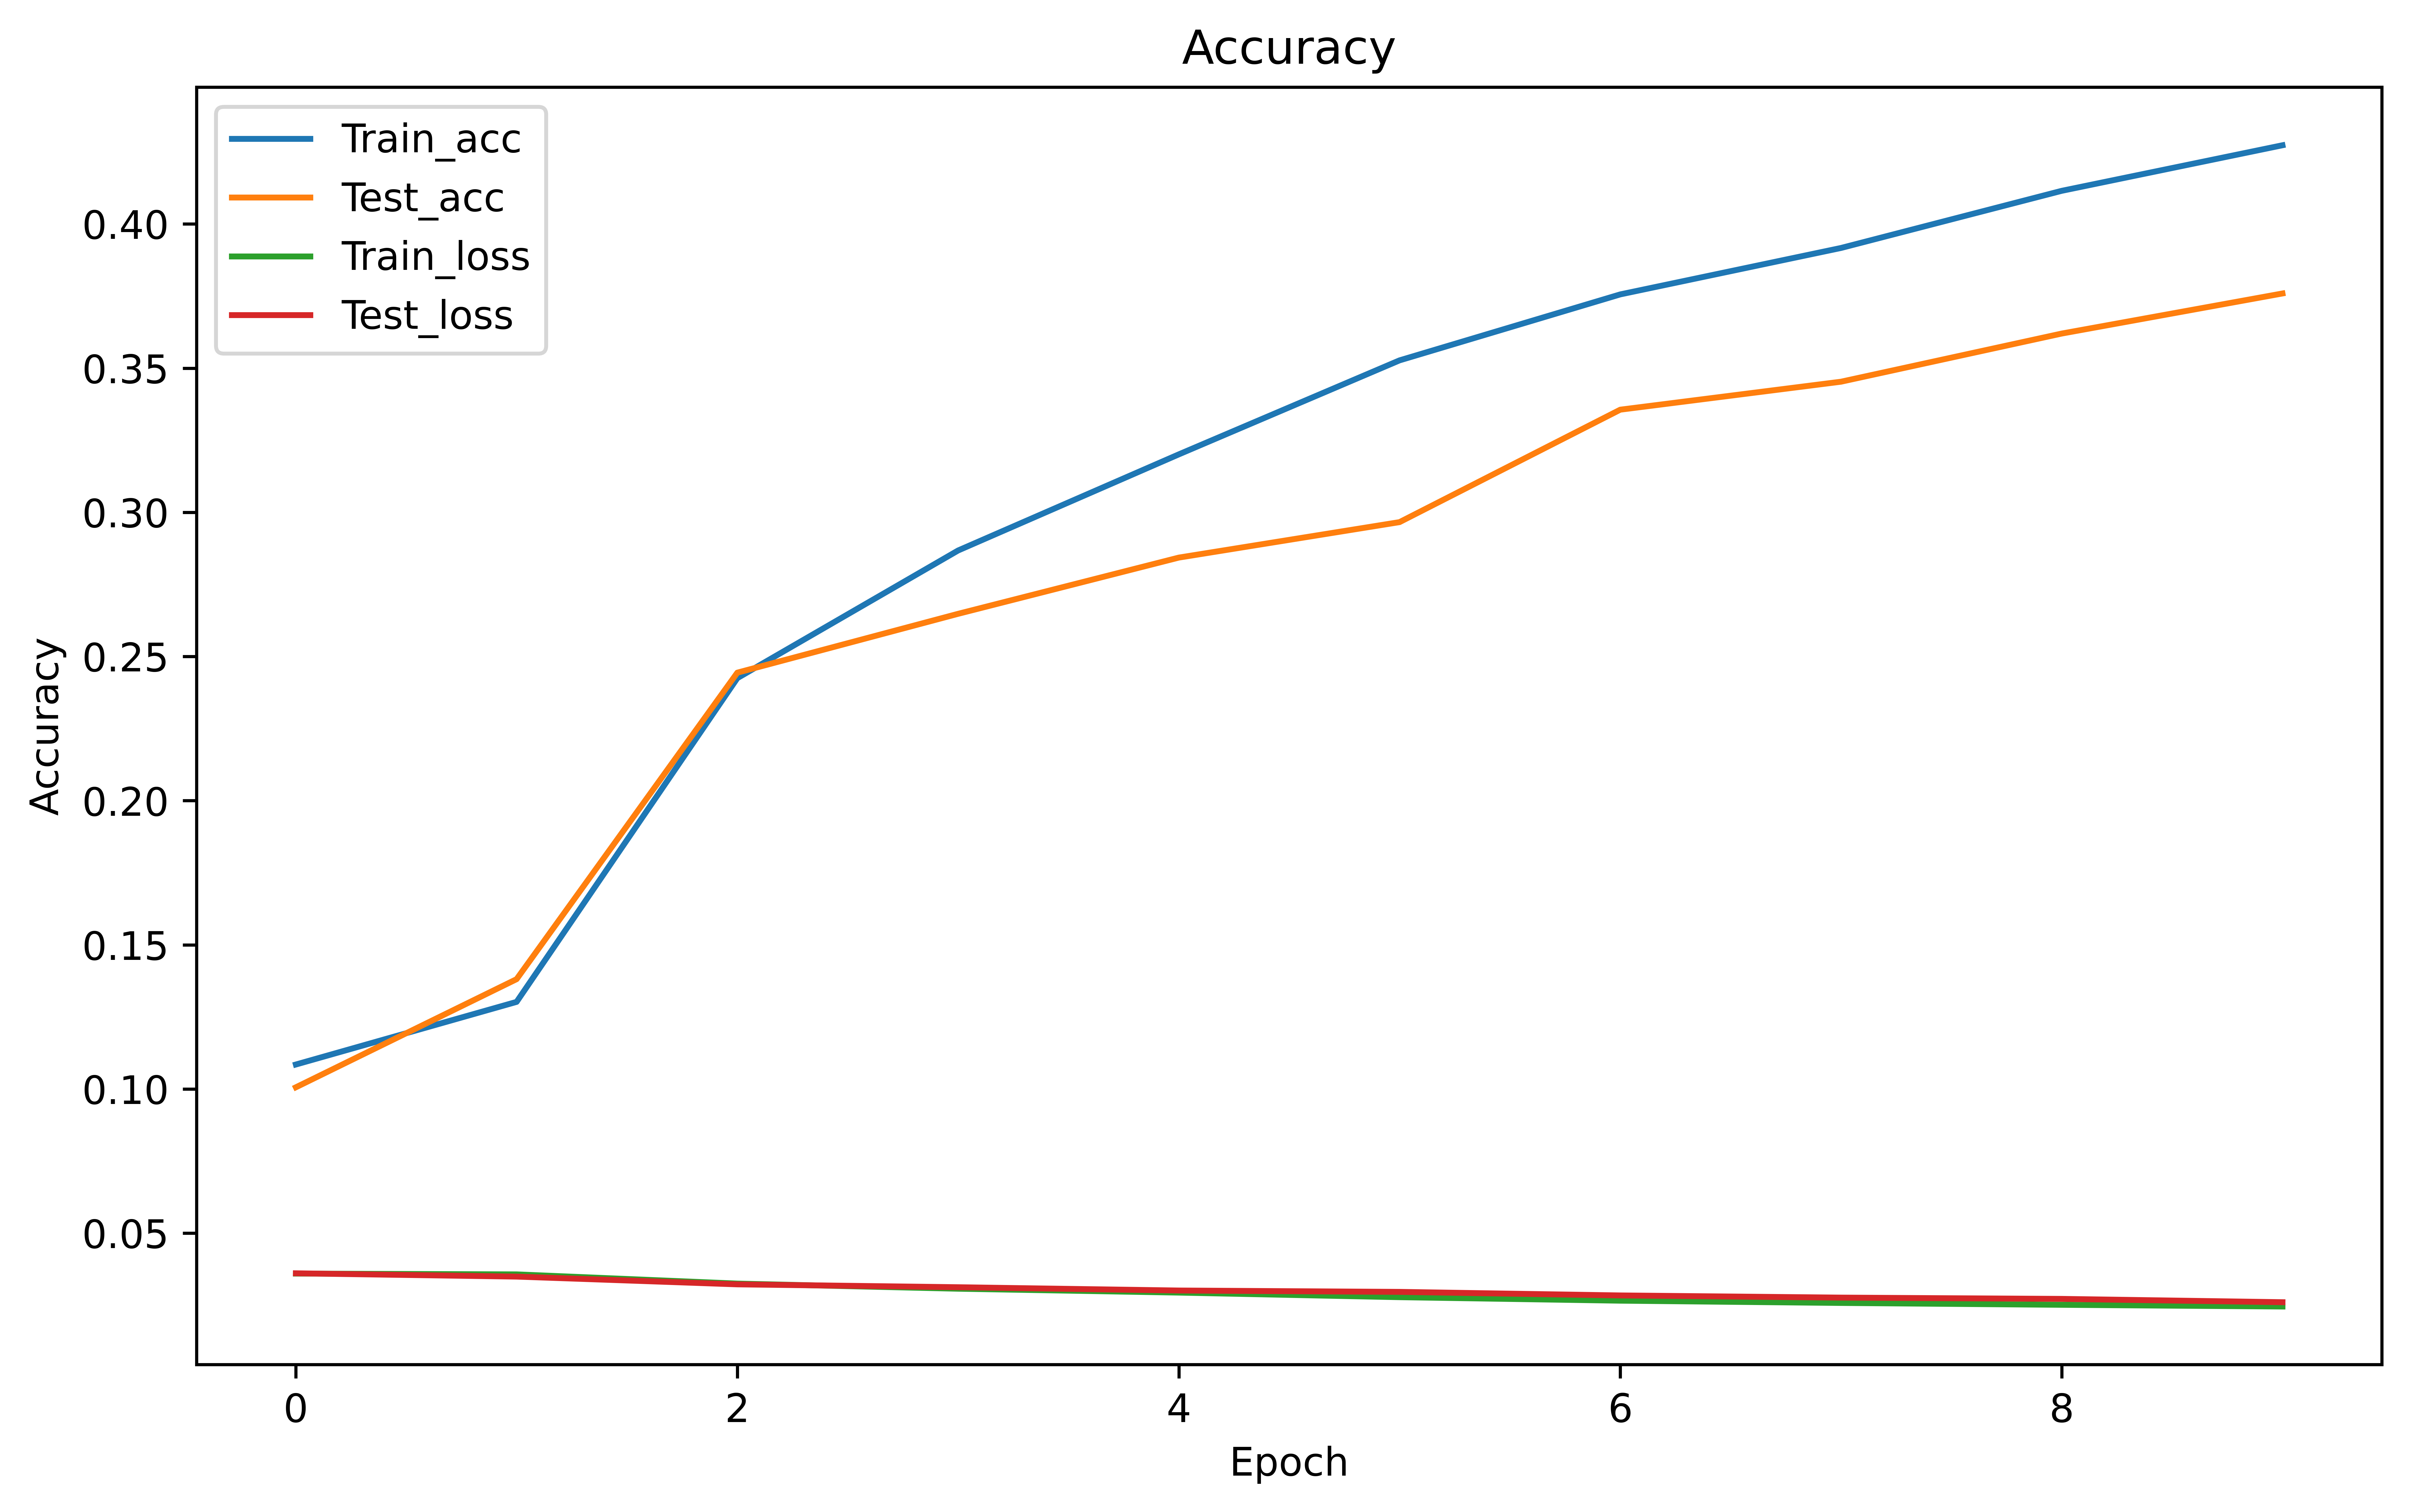

In [18]:
plot('CIFAR10', 'WD', exp_num)